In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from importlib import reload 

In [3]:
from deeprank.dataset import DataLoader, PairGenerator, ListGenerator
from deeprank import utils

In [4]:
seed = 1234
torch.manual_seed(seed)

In [5]:
loader = DataLoader('./config/letor07_mp_fold1.model')

[./data/letor/r5w/word_dict.txt]
	Word dict size: 193367
[./data/letor/r5w/qid_query.txt]
	Data size: 1692
[./data/letor/r5w/docid_doc.txt]
	Data size: 65323
[./data/letor/r5w/embed_wiki-pdc_d50_norm]
	Embedding size: 109282
[./data/letor/r5w/embed.idf]
	Embedding size: 193367
Generate numpy embed: (193368, 50)
Generate numpy embed: (193368, 1)


In [6]:
import json
letor_config = json.loads(open('./config/letor07_mp_fold1.model').read())
#device = torch.device("cuda")
#device = torch.device("cpu")
select_device = torch.device("cpu")
rank_device = torch.device("cuda")

In [7]:
Letor07Path = letor_config['data_dir']

letor_config['fill_word'] = loader._PAD_
letor_config['embedding'] = loader.embedding
letor_config['feat_size'] = loader.feat_size
letor_config['vocab_size'] = loader.embedding.shape[0]
letor_config['embed_dim'] = loader.embedding.shape[1]
letor_config['pad_value'] = loader._PAD_

pair_gen = PairGenerator(rel_file=Letor07Path + '/relation.train.fold%d.txt'%(letor_config['fold']), 
                         config=letor_config)

[./data/letor/r5w/relation.train.fold1.txt]
	Instance size: 47828
Pair Instance Count: 325439


In [8]:
from deeprank import select_module
from deeprank import rank_module

In [9]:
'''
letor_config['max_match'] = 20
letor_config['win_size'] = 5
select_net = select_module.QueryCentricNet(config=letor_config, out_device=rank_device)
select_net = select_net.to(select_device)
select_net.train()
'''

"\nletor_config['max_match'] = 20\nletor_config['win_size'] = 5\nselect_net = select_module.QueryCentricNet(config=letor_config, out_device=rank_device)\nselect_net = select_net.to(select_device)\nselect_net.train()\n"

In [10]:
letor_config['q_limit'] = 20
letor_config['d_limit'] = 2000

letor_config['max_match'] = 5
letor_config['win_size'] = 5

letor_config['q_rep_dim'] = 10
letor_config['d_rep_dim'] = 10
letor_config['q_rep_kernel'] = 3
letor_config['d_rep_kernel'] = letor_config['win_size']*2+1

letor_config['finetune_embed'] = False
letor_config['lr'] = 0.0001
select_net = select_module.GroupPointerNet(config=letor_config, out_device=rank_device)
select_net = select_net.to(select_device)
select_net.embedding.weight.data.copy_(torch.from_numpy(loader.embedding))
select_net.train()
select_optimizer = optim.RMSprop(select_net.parameters(), lr=letor_config['lr'])

In [11]:
letor_config["dim_q"] = 1
letor_config["dim_d"] = 1
letor_config["dim_weight"] = 1
letor_config["c_reduce"] = [1, 1]
letor_config["k_reduce"] = [1, 50]
letor_config["s_reduce"] = 1
letor_config["p_reduce"] = [0, 0]

letor_config["c_en_conv_out"] = 4
letor_config["k_en_conv"] = 3
letor_config["s_en_conv"] = 1
letor_config["p_en_conv"] = 1

letor_config["en_pool_out"] = [1, 1]
letor_config["en_leaky"] = 0.2

letor_config["dim_gru_hidden"] = 3

letor_config['lr'] = 0.005
letor_config['finetune_embed'] = False

rank_net = rank_module.DeepRankNet(config=letor_config)
rank_net = rank_net.to(rank_device)
rank_net.embedding.weight.data.copy_(torch.from_numpy(loader.embedding))
rank_net.qw_embedding.weight.data.copy_(torch.from_numpy(loader.idf_embedding))
rank_net.train()
rank_optimizer = optim.Adam(rank_net.parameters(), lr=letor_config['lr'])

In [12]:
def to_device(*variables, device):
    return (torch.from_numpy(variable).to(device) for variable in variables)

In [13]:
def to_device_raw(*variables, device):
    return (variable.to(device) for variable in variables)

In [14]:
def show_text(x):
    print(' '.join([loader.word_dict[w.item()] for w in x]))

In [15]:
X1, X1_len, X1_id, X2, X2_len, X2_id, Y, F = \
        pair_gen.get_batch(data1=loader.query_data, data2=loader.doc_data)
X1, X1_len, X2, X2_len, Y, F = \
        to_device(X1, X1_len, X2, X2_len, Y, F, device=select_device)

show_text(X2[0])

X1, X2_new, X1_len, X2_len_new, X2_pos = select_net(X1, X2, X1_len, X2_len, X1_id, X2_id)

show_text(X1[0])
for i in range(5):
    print(i, end=' ')
    show_text(X2_new[0][i])

vdgif regulation regulation action vac final home regulation regulation action vac final vac game turkey vac game turkey open season county area monday october hunting days following thanksgiving monday closest december five hunting days following vac game turkey open season spring season bearded turkey vac game turkey continuous closed season county city area vac game turkey tag turkey obtain official game check card licensee vac new game turkey validate tag check turkey licensee vac game turkey tag turkey obtain official game tag person exempt license requirement vac new game turkey check turkey person exempt license requirement holding license authorization number summary vac open season county area monday october hunting days following thanksgiving monday closest december five hunting days following amendment increase fall turkey hunting season six hunting days county charles city gloucester james city king george lancaster middlesex new kent northumberland richmond westmoreland yo

virginia turkey season $$ [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
0 carcass left unattended written documentation secure attach carcass successful hunter shall
1 pursuant e holder virginia license authorization number issue telephone electronic media
2 hunt saturday april half hour sunrise noon prevailing time compliance applicable
3 carcass given game check card telecheck confirmation number successful hunter shall
4 identity sex turkey kill license tag validate notch checked require section


In [16]:
X1, X1_len, X1_id, X2, X2_len, X2_id, Y, F = \
        pair_gen.get_batch(data1=loader.query_data, data2=loader.doc_data)
X1, X1_len, X2, X2_len, Y, F = \
        to_device(X1, X1_len, X2, X2_len, Y, F, device=select_device)

show_text(X2[0])

X1, X2_new, X1_len, X2_len_new, X2_pos = select_net(X1, X2, X1_len, X2_len, X1_id, X2_id)

show_text(X1[0])
for i in range(5):
    print(i, end=' ')
    show_text(X2_new[0][i])

overseas employment information teacher print friendly version overseas employment information teacher following list organization information compile help foreign service family member interested teaching career overseas addition contact organization mention handout wish contact directly school located city country assign overseas school assist department state america sponsor overseas school assist department state office overseas school opr os nonprofit non denominational independent school establish cooperative basis america citizen living overseas school received grant assistance technical support opr os private institution school hire staff hire foreign service spouse opr os update publish annual directory school information organization involved recruit teacher administrator international school world opr os information university offering teacher certificate professional development program overseas location office overseas school department state washington dc tel fax e mail s

employment overseas $$ [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
0 city country assign overseas school assist department state america sponsor overseas
1 friendly version overseas employment information teacher following list organization information compile
2 school university teaching experience require application made united states recruit office
3 edu program department defense dependent school dodd department defense recruit teacher
4 fall lab school washington reservoir road nw washington dc tel fax


In [17]:
print(X2_pos[0].shape)
print(len(X2_pos))
print(len(X2))
print(X2_pos[0])
print(X2_pos[1])

torch.Size([15])
200
200
tensor([  7.,   1.,  72.,  50., 117.,  37., 137.,  23.,  70.,  38., 124., 118.,
        137., 130.,  23.], device='cuda:0')
tensor([40., 17.,  5., 39., 31., 27.,  9., 70., 40., 60., 27., 75., 48., 77.,
        36.], device='cuda:0')


In [18]:
# X1 = X1[:1]
# X1_len = X1_len[:1]
# X2 = X2[:1]
# X2_len = X2_len[:1]
# X1_id = X1_id[:1]
# X2_id = X2_id[:1]

In [19]:
# show_text(X2[0])
# X1, X2_new, X1_len, X2_len_new = select_net(X1, X2, X1_len, X2_len, X1_id, X2_id)
# show_text(X1[0])
# for i in range(5):
#     print(i, end=' ')
#     show_text(X2_new[0][i])

In [20]:
print(X2_pos[i][:,None].shape)
print(X2[i].shape)

torch.Size([20, 1])
torch.Size([2000])


In [21]:
import time

rank_loss_list = []
select_loss_list = []

start_t = time.time()
for i in range(5000):
    # One Step Forward
    X1, X1_len, X1_id, X2, X2_len, X2_id, Y, F = \
        pair_gen.get_batch(data1=loader.query_data, data2=loader.doc_data)
    X1, X1_len, X2, X2_len, Y, F = \
        to_device(X1, X1_len, X2, X2_len, Y, F, device=select_device)
    X1, X2, X1_len, X2_len, X2_pos = select_net(X1, X2, X1_len, X2_len, X1_id, X2_id)
    X2, X2_len = utils.data_adaptor(X2, X2_len, select_net, rank_net, letor_config)
    output = rank_net(X1, X2, X1_len, X2_len, X2_pos)
    reward = rank_net.pair_reward(output, mode=0)
    
    # Update Rank Net
    rank_loss = rank_net.pair_loss(output, Y)
    print('rank loss:', rank_loss.item())
    rank_loss_list.append(rank_loss.item())
    if i % 1 == 0:
        rank_optimizer.zero_grad()
        rank_loss.backward()
        rank_optimizer.step()
    
    # Update Select Net
    select_loss = select_net.loss(reward)
    print('select loss:', select_loss.item())
    select_loss_list.append(select_loss.item())
    select_optimizer.zero_grad()
    select_loss.backward()
    select_optimizer.step()
    
end_t = time.time()
print('Time Cost: %s s' % (end_t-start_t))

rank loss: 1.061739206314087
select loss: -8.932861328125
rank loss: 0.7990149259567261
select loss: -76.96783447265625
rank loss: 0.8184126615524292
select loss: -99.08746337890625
rank loss: 0.9081184267997742
select loss: -14.963592529296875
rank loss: 0.887549638748169
select loss: -78.71176147460938
rank loss: 0.8554229736328125
select loss: -79.35688781738281
rank loss: 0.9790788888931274
select loss: -52.58917999267578
rank loss: 0.9098882675170898
select loss: -82.24967956542969
rank loss: 0.8661596775054932
select loss: -56.108821868896484
rank loss: 0.8622142672538757
select loss: -54.950538635253906
rank loss: 0.8566358685493469
select loss: -39.43813705444336
rank loss: 0.8468168377876282
select loss: -46.63654708862305
rank loss: 0.7533923387527466
select loss: -97.93757629394531
rank loss: 0.8986533880233765
select loss: -77.06200408935547
rank loss: 0.9085837602615356
select loss: -67.49925231933594
rank loss: 0.9280178546905518
select loss: -49.53486633300781
rank loss:

select loss: -41.874053955078125
rank loss: 0.905791163444519
select loss: -46.598716735839844
rank loss: 0.8482679724693298
select loss: -97.40786743164062
rank loss: 0.9712994694709778
select loss: 2.9692330360412598
rank loss: 0.9047505259513855
select loss: -53.792022705078125
rank loss: 0.8809759616851807
select loss: -79.48902130126953
rank loss: 0.8172101974487305
select loss: -118.86722564697266
rank loss: 0.8813660740852356
select loss: -57.43522644042969
rank loss: 0.7990936040878296
select loss: -111.71832275390625
rank loss: 0.8193174004554749
select loss: -79.47256469726562
rank loss: 0.8066471815109253
select loss: -83.0624771118164
rank loss: 0.6835092902183533
select loss: -75.3260269165039
rank loss: 0.851616621017456
select loss: -83.07035064697266
rank loss: 0.7475734353065491
select loss: -125.46353149414062
rank loss: 0.7530995011329651
select loss: -114.06275177001953
rank loss: 0.8742584586143494
select loss: -74.73799133300781
rank loss: 0.8365135192871094
selec

select loss: -93.23555755615234
rank loss: 0.944330096244812
select loss: -57.391990661621094
rank loss: 0.8112713694572449
select loss: -106.4113540649414
rank loss: 0.8090644478797913
select loss: -68.16313171386719
rank loss: 0.790381908416748
select loss: -51.4814453125
rank loss: 0.8663913607597351
select loss: -82.4738998413086
rank loss: 0.8706327080726624
select loss: -59.17923355102539
rank loss: 0.8068073987960815
select loss: -104.59782409667969
rank loss: 0.8979910612106323
select loss: -47.82130432128906
rank loss: 0.8328897953033447
select loss: -109.4009017944336
rank loss: 0.7913498282432556
select loss: -96.84735107421875
rank loss: 0.7148754000663757
select loss: -102.25397491455078
rank loss: 0.8100387454032898
select loss: -67.56645965576172
rank loss: 0.9019309878349304
select loss: -30.47629165649414
rank loss: 0.9836360216140747
select loss: -7.159656524658203
rank loss: 0.8948732018470764
select loss: -72.34407043457031
rank loss: 0.7418608069419861
select loss:

rank loss: 0.7956671118736267
select loss: -83.09761047363281
rank loss: 0.8002563118934631
select loss: -95.12133026123047
rank loss: 0.7199399471282959
select loss: -124.40544891357422
rank loss: 0.9466931223869324
select loss: -24.529211044311523
rank loss: 0.965021014213562
select loss: -35.87236785888672
rank loss: 0.9666966795921326
select loss: 8.952542304992676
rank loss: 0.7643223404884338
select loss: -104.03938293457031
rank loss: 0.8208138942718506
select loss: -86.70341491699219
rank loss: 0.796794056892395
select loss: -68.77533721923828
rank loss: 0.7791937589645386
select loss: -71.12507629394531
rank loss: 0.7486233115196228
select loss: -117.83199310302734
rank loss: 0.8057717680931091
select loss: -91.5113296508789
rank loss: 0.8226779103279114
select loss: -46.68033218383789
rank loss: 0.8610132932662964
select loss: -55.022891998291016
rank loss: 0.7383981943130493
select loss: -102.87681579589844
rank loss: 0.8578963279724121
select loss: -94.45892333984375
rank l

select loss: -89.75753021240234
rank loss: 0.6689431667327881
select loss: -122.61681365966797
rank loss: 0.8217815160751343
select loss: -67.61410522460938
rank loss: 0.716945469379425
select loss: -121.43791198730469
rank loss: 0.8547750115394592
select loss: -65.81327056884766
rank loss: 0.7599259614944458
select loss: -64.61143493652344
rank loss: 0.8049276471138
select loss: -92.69465637207031
rank loss: 0.927007257938385
select loss: -27.53447723388672
rank loss: 0.912106454372406
select loss: -60.438297271728516
rank loss: 0.7675154209136963
select loss: -101.10340881347656
rank loss: 0.8762836456298828
select loss: -40.09443664550781
rank loss: 0.8798931837081909
select loss: -42.483795166015625
rank loss: 0.9394338130950928
select loss: -33.52280807495117
rank loss: 0.7859898209571838
select loss: -78.36425018310547
rank loss: 0.8581708073616028
select loss: -95.09658813476562
rank loss: 0.6723262071609497
select loss: -134.00439453125
rank loss: 0.8569785356521606
select loss

rank loss: 0.803485631942749
select loss: -90.3714370727539
rank loss: 0.709141731262207
select loss: -88.53614044189453
rank loss: 0.838416337966919
select loss: -84.35537719726562
rank loss: 0.8845017552375793
select loss: -69.43934631347656
rank loss: 0.8722471594810486
select loss: -83.75348663330078
rank loss: 0.759783923625946
select loss: -82.576171875
rank loss: 0.8305010795593262
select loss: -78.98635864257812
rank loss: 0.7479103207588196
select loss: -163.34100341796875
rank loss: 0.7131384015083313
select loss: -92.15321350097656
rank loss: 0.7488065361976624
select loss: -83.16210174560547
rank loss: 0.7046359777450562
select loss: -117.87503814697266
rank loss: 0.7570599317550659
select loss: -81.99946594238281
rank loss: 0.8218250870704651
select loss: -55.0499382019043
rank loss: 0.692003607749939
select loss: -102.9374771118164
rank loss: 0.8135331273078918
select loss: -104.68006896972656
rank loss: 0.7910826206207275
select loss: -61.622802734375
rank loss: 0.918811

select loss: -116.08906555175781
rank loss: 0.8244601488113403
select loss: -65.2229232788086
rank loss: 0.7652285695075989
select loss: -150.19960021972656
rank loss: 0.8023413419723511
select loss: -39.51240921020508
rank loss: 0.8754934668540955
select loss: -46.678741455078125
rank loss: 0.9041462540626526
select loss: -31.127370834350586
rank loss: 0.7277922034263611
select loss: -86.16265869140625
rank loss: 0.7553762793540955
select loss: -95.75813293457031
rank loss: 0.7087594270706177
select loss: -166.34400939941406
rank loss: 0.8626461625099182
select loss: -77.20269775390625
rank loss: 0.7663664221763611
select loss: -110.70205688476562
rank loss: 0.846065878868103
select loss: -56.239315032958984
rank loss: 0.7641112208366394
select loss: -88.58100891113281
rank loss: 0.7116456627845764
select loss: -102.91173553466797
rank loss: 0.7867386937141418
select loss: -97.54163360595703
rank loss: 0.7059128880500793
select loss: -128.05184936523438
rank loss: 0.8326395750045776
s

select loss: -86.77964782714844
rank loss: 0.8102158904075623
select loss: -56.854400634765625
rank loss: 0.7091296911239624
select loss: -104.13175964355469
rank loss: 0.6313104629516602
select loss: -129.270263671875
rank loss: 1.0079505443572998
select loss: -60.454158782958984
rank loss: 0.7780483365058899
select loss: -102.9375
rank loss: 0.845256507396698
select loss: -80.79783630371094
rank loss: 0.7625504732131958
select loss: -60.445213317871094
rank loss: 0.8511845469474792
select loss: -76.60491180419922
rank loss: 0.9215095043182373
select loss: -16.759662628173828
rank loss: 0.8473708629608154
select loss: -70.02069854736328
rank loss: 0.8014504909515381
select loss: -120.28511047363281
rank loss: 0.8300043940544128
select loss: -77.19635772705078
rank loss: 0.8924158811569214
select loss: -58.64814376831055
rank loss: 0.8202757239341736
select loss: -91.5749282836914
rank loss: 0.6641405820846558
select loss: -175.94154357910156
rank loss: 0.8066885471343994
select loss: 

rank loss: 0.7928279042243958
select loss: -44.285701751708984
rank loss: 0.8013404011726379
select loss: -79.00546264648438
rank loss: 0.8161352872848511
select loss: -93.96533203125
rank loss: 0.6229777336120605
select loss: -140.6394500732422
rank loss: 0.7307490110397339
select loss: -75.40180969238281
rank loss: 1.0362471342086792
select loss: -38.308860778808594
rank loss: 0.9099013805389404
select loss: -94.56629943847656
rank loss: 0.7600894570350647
select loss: -98.16140747070312
rank loss: 0.7119529843330383
select loss: -137.04287719726562
rank loss: 0.695321798324585
select loss: -116.09940338134766
rank loss: 0.6788529753684998
select loss: -111.32313537597656
rank loss: 0.749876856803894
select loss: -113.12137603759766
rank loss: 0.8279152512550354
select loss: -73.01844024658203
rank loss: 0.7265118360519409
select loss: -105.33795166015625
rank loss: 0.9162194728851318
select loss: -65.8392105102539
rank loss: 0.6615999341011047
select loss: -120.8995132446289
rank lo

select loss: -84.3945541381836
rank loss: 0.7158222794532776
select loss: -143.0526123046875
rank loss: 0.8658848404884338
select loss: -70.62691497802734
rank loss: 0.79393070936203
select loss: -102.34252166748047
rank loss: 0.6954379677772522
select loss: -154.42221069335938
rank loss: 0.955078661441803
select loss: -20.35893440246582
rank loss: 0.8795450925827026
select loss: -53.8541145324707
rank loss: 0.8848141431808472
select loss: -58.658538818359375
rank loss: 0.9094986319541931
select loss: -96.36691284179688
rank loss: 0.7931707501411438
select loss: -101.14738464355469
rank loss: 0.7152325510978699
select loss: -106.53453063964844
rank loss: 0.9890361428260803
select loss: -49.680816650390625
rank loss: 0.7620628476142883
select loss: -129.87533569335938
rank loss: 0.812540590763092
select loss: -54.465789794921875
rank loss: 0.5600150227546692
select loss: -176.5604705810547
rank loss: 0.9056227803230286
select loss: -84.98992156982422
rank loss: 0.8862167000770569
select

rank loss: 0.8731551766395569
select loss: -54.470741271972656
rank loss: 0.8869001865386963
select loss: -53.8692512512207
rank loss: 0.7304966449737549
select loss: -156.22116088867188
rank loss: 0.8311312198638916
select loss: -118.51156616210938
rank loss: 0.6197469830513
select loss: -144.84889221191406
rank loss: 0.9182085990905762
select loss: -105.32720947265625
rank loss: 0.7549470067024231
select loss: -73.01998901367188
rank loss: 0.8410855531692505
select loss: -82.60480499267578
rank loss: 1.0198456048965454
select loss: -34.1215705871582
rank loss: 0.7963682413101196
select loss: -111.93276977539062
rank loss: 0.8092672824859619
select loss: -90.38050079345703
rank loss: 0.810401976108551
select loss: -75.42536163330078
rank loss: 0.8554219007492065
select loss: -97.56888580322266
rank loss: 0.674327552318573
select loss: -166.9998016357422
rank loss: 0.8457518815994263
select loss: -84.39441680908203
rank loss: 0.658879816532135
select loss: -128.68858337402344
rank loss

rank loss: 0.7491245269775391
select loss: -113.73002624511719
rank loss: 0.7579229474067688
select loss: -88.59130096435547
rank loss: 0.9688621163368225
select loss: 19.152631759643555
rank loss: 0.8553454279899597
select loss: -84.99392700195312
rank loss: 1.0243854522705078
select loss: -88.59142303466797
rank loss: 0.8868427872657776
select loss: -65.84720611572266
rank loss: 0.9124370217323303
select loss: -83.2010269165039
rank loss: 0.7090885639190674
select loss: -148.4459991455078
rank loss: 0.7739880084991455
select loss: -96.97042083740234
rank loss: 0.7333775758743286
select loss: -110.13794708251953
rank loss: 0.5423483848571777
select loss: -207.10763549804688
rank loss: 0.9533914923667908
select loss: -107.14369201660156
rank loss: 0.8632665872573853
select loss: -98.16671752929688
rank loss: 0.9085859656333923
select loss: -61.654762268066406
rank loss: 0.8542232513427734
select loss: -80.21027374267578
rank loss: 0.8128085136413574
select loss: -77.2142333984375
rank 

select loss: -115.52933502197266
rank loss: 0.8621739149093628
select loss: -80.2099380493164
rank loss: 0.7336593270301819
select loss: -83.8023910522461
rank loss: 0.8014428019523621
select loss: -85.59964752197266
rank loss: 0.7904857993125916
select loss: -113.13543701171875
rank loss: 0.6891074776649475
select loss: -123.91032409667969
rank loss: 0.7853668332099915
select loss: -50.283111572265625
rank loss: 0.7464131116867065
select loss: -77.81871032714844
rank loss: 0.6815366744995117
select loss: -88.59234619140625
rank loss: 0.7592698335647583
select loss: -117.92371368408203
rank loss: 0.8219087719917297
select loss: -60.45905685424805
rank loss: 0.729334831237793
select loss: -105.35514831542969
rank loss: 0.7022215127944946
select loss: -82.00727844238281
rank loss: 0.7461094260215759
select loss: -132.88938903808594
rank loss: 0.7125280499458313
select loss: -122.11714172363281
rank loss: 0.8783235549926758
select loss: -85.59785461425781
rank loss: 0.7899736762046814
sel

select loss: -52.07899475097656
rank loss: 0.8216981291770935
select loss: -71.23255920410156
rank loss: 0.7396600842475891
select loss: -128.10345458984375
rank loss: 0.6394104361534119
select loss: -111.34046936035156
rank loss: 0.886584460735321
select loss: -85.6012191772461
rank loss: 0.7520381212234497
select loss: -73.6279525756836
rank loss: 0.7496422529220581
select loss: -98.77190399169922
rank loss: 0.8301258683204651
select loss: -62.254150390625
rank loss: 0.6848146915435791
select loss: -88.59563446044922
rank loss: 0.7816962003707886
select loss: -99.96810913085938
rank loss: 0.7516534924507141
select loss: -107.7505111694336
rank loss: 0.63186115026474
select loss: -161.024658203125
rank loss: 0.9134448170661926
select loss: -53.872764587402344
rank loss: 0.8587671518325806
select loss: -97.572021484375
rank loss: 0.7698251008987427
select loss: -105.35421752929688
rank loss: 0.8706396222114563
select loss: -73.63217163085938
rank loss: 0.7855789661407471
select loss: -

rank loss: 0.751725435256958
select loss: -78.41878509521484
rank loss: 0.7525536417961121
select loss: -125.111328125
rank loss: 0.675250232219696
select loss: -134.68984985351562
rank loss: 0.8055437207221985
select loss: -59.26426315307617
rank loss: 0.8262802958488464
select loss: -84.40596771240234
rank loss: 0.8273263573646545
select loss: -102.9619369506836
rank loss: 0.7614225745201111
select loss: -118.5267562866211
rank loss: 1.0173871517181396
select loss: -38.311031341552734
rank loss: 0.9210667014122009
select loss: -73.0306625366211
rank loss: 1.002200961112976
select loss: -78.41954803466797
rank loss: 0.9321015477180481
select loss: -89.79153442382812
rank loss: 0.9355388283729553
select loss: -81.41099548339844
rank loss: 0.8479079008102417
select loss: -130.50045776367188
rank loss: 0.7874638438224792
select loss: -100.56831359863281
rank loss: 0.860910952091217
select loss: -84.40545654296875
rank loss: 0.9004271030426025
select loss: -18.557653427124023
rank loss: 0

select loss: -113.13929748535156
rank loss: 0.7849971055984497
select loss: -105.95574188232422
rank loss: 0.732105553150177
select loss: -113.73856353759766
rank loss: 0.7917590737342834
select loss: -92.1882553100586
rank loss: 0.7335333824157715
select loss: -143.6693878173828
rank loss: 0.8619720339775085
select loss: -71.23634338378906
rank loss: 0.8610813617706299
select loss: -38.31269836425781
rank loss: 0.8386380076408386
select loss: -62.25627517700195
rank loss: 0.908115565776825
select loss: -85.60246276855469
rank loss: 0.741219162940979
select loss: -107.75212860107422
rank loss: 0.7748004198074341
select loss: -118.52623748779297
rank loss: 0.7199181914329529
select loss: -91.58728790283203
rank loss: 0.8232818245887756
select loss: -90.38960266113281
rank loss: 0.941239595413208
select loss: -53.277488708496094
rank loss: 0.7003242373466492
select loss: -174.1988067626953
rank loss: 0.7210415601730347
select loss: -111.9438705444336
rank loss: 0.8676594495773315
select 

select loss: -93.9848403930664
rank loss: 0.7008905410766602
select loss: -149.05751037597656
rank loss: 0.9042785167694092
select loss: -86.7973403930664
rank loss: 0.8379650115966797
select loss: -78.41868591308594
rank loss: 0.9734567999839783
select loss: -40.706138610839844
rank loss: 0.7562716603279114
select loss: -122.12091827392578
rank loss: 0.7698639035224915
select loss: -76.62430572509766
rank loss: 0.7636538743972778
select loss: -86.80115509033203
rank loss: 0.6678832769393921
select loss: -146.6637420654297
rank loss: 0.7808445692062378
select loss: -108.95028686523438
rank loss: 0.8822861909866333
select loss: -67.04583740234375
rank loss: 0.7375465035438538
select loss: -133.49317932128906
rank loss: 0.9120179414749146
select loss: -37.1147346496582
rank loss: 0.9924145340919495
select loss: -47.889041900634766
rank loss: 0.9198789596557617
select loss: -86.80024719238281
rank loss: 0.8724570870399475
select loss: -65.2502212524414
rank loss: 0.8081836700439453
select

select loss: -137.08609008789062
rank loss: 0.7541084289550781
select loss: -116.73238372802734
rank loss: 0.8770665526390076
select loss: -86.2021713256836
rank loss: 0.7058621048927307
select loss: -99.37279510498047
rank loss: 0.8700224757194519
select loss: -51.48151779174805
rank loss: 0.8531100153923035
select loss: -42.50319290161133
rank loss: 0.7637479901313782
select loss: -82.61099243164062
rank loss: 0.9117767214775085
select loss: -82.6097183227539
rank loss: 0.8442976474761963
select loss: -62.85606384277344
rank loss: 0.779251754283905
select loss: -127.50848388671875
rank loss: 0.8234772086143494
select loss: -50.883968353271484
rank loss: 0.6671998500823975
select loss: -110.74734497070312
rank loss: 0.9632476568222046
select loss: -59.264225006103516
rank loss: 0.8094167709350586
select loss: -58.0673942565918
rank loss: 0.8260965347290039
select loss: -75.42805480957031
rank loss: 0.8089120388031006
select loss: -122.71980285644531
rank loss: 0.8578152060508728
selec

select loss: -57.469093322753906
rank loss: 0.8554347157478333
select loss: -76.0263442993164
rank loss: 0.788172721862793
select loss: -98.77445983886719
rank loss: 0.8557156324386597
select loss: -86.20452880859375
rank loss: 0.8934929966926575
select loss: -71.23797607421875
rank loss: 0.7792941331863403
select loss: -59.26460266113281
rank loss: 0.7650454640388489
select loss: -52.680328369140625
rank loss: 0.7764667868614197
select loss: -28.734060287475586
rank loss: 0.8487414121627808
select loss: -50.28593826293945
rank loss: 0.7901919484138489
select loss: -125.71314239501953
rank loss: 0.8854720592498779
select loss: -58.067020416259766
rank loss: 0.8249003291130066
select loss: -76.0266342163086
rank loss: 0.6533802151679993
select loss: -134.0930633544922
rank loss: 0.8607050776481628
select loss: -54.474273681640625
rank loss: 0.9293691515922546
select loss: -76.62466430664062
rank loss: 0.9329922199249268
select loss: -38.91083908081055
rank loss: 0.8456676006317139
selec

select loss: -85.60513305664062
rank loss: 0.7486060857772827
select loss: -104.76087188720703
rank loss: 0.8729891180992126
select loss: -76.62487030029297
rank loss: 0.7440499067306519
select loss: -95.1832046508789
rank loss: 0.8964206576347351
select loss: -67.6455307006836
rank loss: 0.9738879203796387
select loss: -55.67323303222656
rank loss: 0.7809240818023682
select loss: -87.40126037597656
rank loss: 0.8584582209587097
select loss: -77.82250213623047
rank loss: 0.734369158744812
select loss: -125.11441040039062
rank loss: 0.8885236978530884
select loss: -48.489990234375
rank loss: 0.9277924299240112
select loss: -16.163923263549805
rank loss: 0.9317224025726318
select loss: -57.46916961669922
rank loss: 0.9354293346405029
select loss: -30.530712127685547
rank loss: 0.8910438418388367
select loss: -29.333297729492188
rank loss: 0.9321298003196716
select loss: -50.883697509765625
rank loss: 0.8309749364852905
select loss: -80.81481170654297
rank loss: 0.756794273853302
select l

rank loss: 0.8826524019241333
select loss: -51.483131408691406
rank loss: 0.8337473273277283
select loss: -79.61872863769531
rank loss: 0.6174314618110657
select loss: -156.8424072265625
rank loss: 0.9046662449836731
select loss: -86.20308685302734
rank loss: 0.7900058031082153
select loss: -121.52285766601562
rank loss: 0.7490857243537903
select loss: -106.55610656738281
rank loss: 0.8636893033981323
select loss: -61.05897903442383
rank loss: 0.8934934139251709
select loss: -40.1086540222168
rank loss: 0.7641716003417969
select loss: -114.93753814697266
rank loss: 0.953785240650177
select loss: -22.149259567260742
rank loss: 0.8153425455093384
select loss: -96.97864532470703
rank loss: 0.8941085338592529
select loss: -71.23786163330078
rank loss: 0.7326963543891907
select loss: -135.29156494140625
rank loss: 0.7796242833137512
select loss: -89.79432678222656
rank loss: 1.0081363916397095
select loss: -37.71358871459961
rank loss: 0.7003656029701233
select loss: -85.60478210449219
rank

select loss: -98.17536926269531
rank loss: 0.7461013793945312
select loss: -86.80230712890625
rank loss: 0.8780784606933594
select loss: -36.51764678955078
rank loss: 0.8929247260093689
select loss: -87.99951934814453
rank loss: 0.8766970038414001
select loss: -84.40736389160156
rank loss: 0.6610434651374817
select loss: -147.86204528808594
rank loss: 1.0036348104476929
select loss: -65.24882507324219
rank loss: 0.8217730522155762
select loss: -89.79414367675781
rank loss: 0.9770293831825256
select loss: -48.48974609375
rank loss: 0.848984956741333
select loss: -73.0320053100586
rank loss: 0.9497449398040771
select loss: -50.2856330871582
rank loss: 0.8662365674972534
select loss: -75.4281997680664
rank loss: 0.8429716229438782
select loss: -82.01280975341797
rank loss: 0.7875739932060242
select loss: -74.82941436767578
rank loss: 0.8533013463020325
select loss: -90.99250030517578
rank loss: 0.9982908964157104
select loss: -43.10185241699219
rank loss: 0.9186680316925049
select loss: -

rank loss: 0.957463264465332
select loss: -73.0331802368164
rank loss: 0.7554296851158142
select loss: -122.72067260742188
rank loss: 0.7344018220901489
select loss: -107.15596008300781
rank loss: 0.7362245917320251
select loss: -119.12820434570312
rank loss: 0.7494558691978455
select loss: -96.97716522216797
rank loss: 0.837169885635376
select loss: -87.99884033203125
rank loss: 0.746185839176178
select loss: -111.34378051757812
rank loss: 0.7663467526435852
select loss: -112.5433120727539
rank loss: 0.8394749760627747
select loss: -49.6872673034668
rank loss: 0.7465612888336182
select loss: -134.094482421875
rank loss: 0.7143549919128418
select loss: -95.1823501586914
rank loss: 0.8754467368125916
select loss: -71.23755645751953
rank loss: 1.0289828777313232
select loss: 20.35315704345703
rank loss: 0.9534714818000793
select loss: -70.63813781738281
rank loss: 0.9488820433616638
select loss: -87.40101623535156
rank loss: 0.7222709655761719
select loss: -130.5025634765625
rank loss: 0

rank loss: 0.8547694087028503
select loss: -61.65971755981445
rank loss: 0.8670055866241455
select loss: -111.94519805908203
rank loss: 0.569560170173645
select loss: -162.82846069335938
rank loss: 0.8698728680610657
select loss: -96.97775268554688
rank loss: 0.7467936277389526
select loss: -113.14187622070312
rank loss: 0.8493058681488037
select loss: -81.41478729248047
rank loss: 0.7096661925315857
select loss: -134.69314575195312
rank loss: 0.9070156812667847
select loss: -35.319549560546875
rank loss: 0.8265188336372375
select loss: -84.40792083740234
rank loss: 0.8978593349456787
select loss: -68.24468994140625
rank loss: 0.847014307975769
select loss: -84.40805053710938
rank loss: 0.9647876024246216
select loss: -55.07423782348633
rank loss: 0.8542888164520264
select loss: -71.23820495605469
rank loss: 0.8258379697799683
select loss: -47.292179107666016
rank loss: 0.8554849028587341
select loss: -76.02698516845703
rank loss: 0.5940432548522949
select loss: -152.0533905029297
rank

rank loss: 0.930924654006958
select loss: -27.53697967529297
rank loss: 0.936347484588623
select loss: -62.85636901855469
rank loss: 0.880631685256958
select loss: -87.40097045898438
rank loss: 0.8547980785369873
select loss: -57.46925354003906
rank loss: 0.7897093296051025
select loss: -98.77496337890625
rank loss: 0.6696586608886719
select loss: -152.0536346435547
rank loss: 0.864695131778717
select loss: -82.6092758178711
rank loss: 0.9393577575683594
select loss: -85.60449981689453
rank loss: 0.858303964138031
select loss: -68.84272003173828
rank loss: 0.7410665154457092
select loss: -128.10806274414062
rank loss: 0.7577494382858276
select loss: -110.74686431884766
rank loss: 0.8104545474052429
select loss: -87.40081787109375
rank loss: 0.8321719765663147
select loss: -94.58467102050781
rank loss: 0.8911833167076111
select loss: -61.65980911254883
rank loss: 0.9250936508178711
select loss: -41.306236267089844
rank loss: 0.873045802116394
select loss: -67.64604949951172
rank loss: 0

select loss: -89.19633483886719
rank loss: 0.8249807357788086
select loss: -105.3595962524414
rank loss: 0.8540239334106445
select loss: -101.76875305175781
rank loss: 0.7759150266647339
select loss: -118.53023529052734
rank loss: 0.7337656021118164
select loss: -95.78145599365234
rank loss: 0.9305989146232605
select loss: -44.8980598449707
rank loss: 0.9914551377296448
select loss: -53.27922439575195
rank loss: 0.7457286715507507
select loss: -99.9723892211914
rank loss: 0.8301913142204285
select loss: -68.24433898925781
rank loss: 0.9275887608528137
select loss: -10.177309036254883
rank loss: 0.939249575138092
select loss: -56.87051773071289
rank loss: 0.8071804046630859
select loss: -82.0130386352539
rank loss: 0.8308934569358826
select loss: -32.925086975097656
rank loss: 0.8371948003768921
select loss: -91.59046936035156
rank loss: 0.9358649849891663
select loss: -56.272216796875
rank loss: 0.8139006495475769
select loss: -99.97189331054688
rank loss: 0.6495346426963806
select los

select loss: -118.53089904785156
rank loss: 0.6992195844650269
select loss: -129.30523681640625
rank loss: 0.7891718745231628
select loss: -90.99303436279297
rank loss: 0.739308774471283
select loss: -95.18321228027344
rank loss: 0.8600170612335205
select loss: -39.509708404541016
rank loss: 0.806099534034729
select loss: -65.85012817382812
rank loss: 0.9851658344268799
select loss: -4.190955638885498
rank loss: 0.8950324654579163
select loss: -59.266029357910156
rank loss: 0.7935616970062256
select loss: -111.94363403320312
rank loss: 0.7523289322853088
select loss: -87.99947357177734
rank loss: 0.928501307964325
select loss: -88.59800720214844
rank loss: 0.8083426356315613
select loss: -96.38021850585938
rank loss: 0.8085511326789856
select loss: -97.57844543457031
rank loss: 0.8162100911140442
select loss: -96.38066101074219
rank loss: 0.7074468731880188
select loss: -129.30520629882812
rank loss: 0.8506671786308289
select loss: -95.18252563476562
rank loss: 0.892647385597229
select

rank loss: 0.7624657154083252
select loss: -86.20416259765625
rank loss: 0.8251446485519409
select loss: -72.43501281738281
rank loss: 0.8011695742607117
select loss: -58.068233489990234
rank loss: 0.7980148792266846
select loss: -93.98612976074219
rank loss: 0.7498911619186401
select loss: -107.15618133544922
rank loss: 0.882059633731842
select loss: -37.71455001831055
rank loss: 0.7882944941520691
select loss: -99.97220611572266
rank loss: 0.7485743761062622
select loss: -118.53067016601562
rank loss: 0.7672343254089355
select loss: -116.73287200927734
rank loss: 0.8459519743919373
select loss: -113.74132537841797
rank loss: 0.7310827374458313
select loss: -117.33308410644531
rank loss: 0.8635883927345276
select loss: -103.5643539428711
rank loss: 0.8707020282745361
select loss: -61.060794830322266
rank loss: 0.6318562030792236
select loss: -147.26461791992188
rank loss: 0.8076510429382324
select loss: -71.83589172363281
rank loss: 1.0766019821166992
select loss: -33.5237922668457
ra

select loss: -89.1971664428711
rank loss: 0.6408445835113525
select loss: -107.75460052490234
rank loss: 0.7730057835578918
select loss: -70.04000854492188
rank loss: 0.6901637315750122
select loss: -179.5911102294922
rank loss: 0.7827482223510742
select loss: -67.64551544189453
rank loss: 0.8377432823181152
select loss: -81.41431427001953
rank loss: 0.9066795110702515
select loss: -53.877647399902344
rank loss: 0.8001700639724731
select loss: -82.61212158203125
rank loss: 0.7137963175773621
select loss: -147.8631591796875
rank loss: 0.7977744936943054
select loss: -62.856868743896484
rank loss: 0.7269867062568665
select loss: -96.9789810180664
rank loss: 0.7620757818222046
select loss: -99.97175598144531
rank loss: 0.717723548412323
select loss: -119.12797546386719
rank loss: 0.7934640049934387
select loss: -93.3866195678711
rank loss: 0.8672714233398438
select loss: -61.65959930419922
rank loss: 0.887287437915802
select loss: -104.16293334960938
rank loss: 0.6978642344474792
select l

rank loss: 0.8375973105430603
select loss: -62.85714340209961
rank loss: 0.9284741282463074
select loss: -49.088905334472656
rank loss: 0.8551535606384277
select loss: -89.79533386230469
rank loss: 0.8822934031486511
select loss: -7.183760166168213
rank loss: 0.8825846910476685
select loss: 1.197098731994629
rank loss: 0.8614727854728699
select loss: -93.98580932617188
rank loss: 0.7424847483634949
select loss: -92.1904067993164
rank loss: 0.8026446104049683
select loss: -70.0402603149414
rank loss: 0.7456049919128418
select loss: -123.31909942626953
rank loss: 0.7574735879898071
select loss: -120.3246078491211
rank loss: 0.7525023221969604
select loss: -69.44145965576172
rank loss: 0.9698443412780762
select loss: -13.17033576965332
rank loss: 0.847846508026123
select loss: -63.45542907714844
rank loss: 0.6815118193626404
select loss: -140.08082580566406
rank loss: 0.8198240399360657
select loss: -107.15496063232422
rank loss: 0.7659255266189575
select loss: -92.18916320800781
rank los

select loss: -58.06813430786133
rank loss: 0.9968511462211609
select loss: -32.925376892089844
rank loss: 0.7704557776451111
select loss: -118.53031158447266
rank loss: 0.8942970037460327
select loss: -68.24514770507812
rank loss: 0.7544906735420227
select loss: -85.60549926757812
rank loss: 0.6642530560493469
select loss: -161.03350830078125
rank loss: 0.8666009306907654
select loss: -123.31690216064453
rank loss: 0.8061655759811401
select loss: -102.36646270751953
rank loss: 0.8884762525558472
select loss: -48.48978042602539
rank loss: 0.807013750076294
select loss: -80.81598663330078
rank loss: 0.80049729347229
select loss: -58.6668815612793
rank loss: 0.8888866901397705
select loss: -82.6122817993164
rank loss: 0.736814022064209
select loss: -90.39408111572266
rank loss: 0.6713840961456299
select loss: -138.88262939453125
rank loss: 0.8015216588973999
select loss: -100.57049560546875
rank loss: 0.79335618019104
select loss: -119.72712707519531
rank loss: 0.707587718963623
select lo

rank loss: 0.9048470258712769
select loss: -44.29917907714844
rank loss: 0.7877737879753113
select loss: -83.80915069580078
rank loss: 0.8307365775108337
select loss: -97.578125
rank loss: 0.7970690727233887
select loss: -83.21084594726562
rank loss: 0.7768309116363525
select loss: -102.36681365966797
rank loss: 0.8748744130134583
select loss: -79.02010345458984
rank loss: 0.8305264115333557
select loss: -83.21096801757812
rank loss: 0.7546493411064148
select loss: -93.98568725585938
rank loss: 0.8900556564331055
select loss: -33.52388000488281
rank loss: 0.8428707718849182
select loss: -72.43514251708984
rank loss: 0.8144441246986389
select loss: -70.63938903808594
rank loss: 0.887875497341156
select loss: -59.864017486572266
rank loss: 0.7775726318359375
select loss: -111.34674072265625
rank loss: 0.6681917905807495
select loss: -118.53034210205078
rank loss: 0.8039867877960205
select loss: -64.65182495117188
rank loss: 0.9094963073730469
select loss: -67.04747772216797
rank loss: 0.

select loss: -63.455535888671875
rank loss: 0.6658998727798462
select loss: -164.02687072753906
rank loss: 0.7159721851348877
select loss: -111.34395599365234
rank loss: 0.8652392625808716
select loss: -114.93773651123047
rank loss: 0.7439761161804199
select loss: -135.8907012939453
rank loss: 0.7306951880455017
select loss: -85.6049575805664
rank loss: 0.790453314781189
select loss: -83.80953216552734
rank loss: 0.9483863711357117
select loss: -87.99972534179688
rank loss: 0.9177189469337463
select loss: -58.66624450683594
rank loss: 0.8373171091079712
select loss: -96.97948455810547
rank loss: 0.8531137108802795
select loss: -81.41470336914062
rank loss: 0.7600976228713989
select loss: -71.83654022216797
rank loss: 0.8359124064445496
select loss: -55.67314910888672
rank loss: 0.8802953958511353
select loss: -74.231689453125
rank loss: 0.8173872232437134
select loss: -106.55738067626953
rank loss: 0.7395658493041992
select loss: -88.59793090820312
rank loss: 0.776375412940979
select l

rank loss: 0.8275509476661682
select loss: -78.42158508300781
rank loss: 0.8389670848846436
select loss: -95.18362426757812
rank loss: 0.7370368838310242
select loss: -89.79574584960938
rank loss: 0.8942680954933167
select loss: -48.489810943603516
rank loss: 0.7632163763046265
select loss: -135.2925262451172
rank loss: 0.5838200449943542
select loss: -147.26414489746094
rank loss: 0.7729440927505493
select loss: -96.37728881835938
rank loss: 0.8403502702713013
select loss: -50.8840217590332
rank loss: 0.8766082525253296
select loss: -52.68031692504883
rank loss: 0.8325068950653076
select loss: -85.60504913330078
rank loss: 0.8193984031677246
select loss: -129.30587768554688
rank loss: 0.7797332406044006
select loss: -126.91024780273438
rank loss: 0.7167297005653381
select loss: -92.18936157226562
rank loss: 0.8059103488922119
select loss: -105.36048126220703
rank loss: 0.7288315892219543
select loss: -93.98625946044922
rank loss: 0.6853365898132324
select loss: -153.8494110107422
rank

rank loss: 0.6915810108184814
select loss: -101.16914367675781
rank loss: 0.7871271967887878
select loss: -120.32513427734375
rank loss: 0.8358561992645264
select loss: -43.10138702392578
rank loss: 0.8733333349227905
select loss: -59.26545715332031
rank loss: 0.8563446402549744
select loss: -86.20325469970703
rank loss: 0.8238368630409241
select loss: -70.63916778564453
rank loss: 0.8332526087760925
select loss: -55.67337417602539
rank loss: 0.7101103067398071
select loss: -113.14247131347656
rank loss: 0.7445514798164368
select loss: -70.04020690917969
rank loss: 0.8281019330024719
select loss: -86.80239868164062
rank loss: 0.786161482334137
select loss: -73.03353881835938
rank loss: 0.7559449672698975
select loss: -96.97940063476562
rank loss: 0.9441283941268921
select loss: -52.67986297607422
rank loss: 0.8271149396896362
select loss: -48.489173889160156
rank loss: 0.9491094946861267
select loss: -34.72156524658203
rank loss: 0.7586906552314758
select loss: -116.13528442382812
rank

rank loss: 0.7903574705123901
select loss: -97.57780456542969
rank loss: 0.8342053890228271
select loss: -98.77548217773438
rank loss: 0.7856934666633606
select loss: -98.1767807006836
rank loss: 0.7447474598884583
select loss: -88.59773254394531
rank loss: 0.9880624413490295
select loss: -7.183918476104736
rank loss: 0.8067518472671509
select loss: -64.05390930175781
rank loss: 0.8161929845809937
select loss: -105.95922088623047
rank loss: 0.8243937492370605
select loss: -114.93768310546875
rank loss: 0.6786651611328125
select loss: -136.48916625976562
rank loss: 0.8934765458106995
select loss: -43.10147476196289
rank loss: 0.7597965598106384
select loss: -62.25809097290039
rank loss: 0.79893958568573
select loss: -121.52318572998047
rank loss: 0.7452401518821716
select loss: -91.59103393554688
rank loss: 0.8496777415275574
select loss: -62.856971740722656
rank loss: 0.7452653050422668
select loss: -123.91845703125
rank loss: 0.746986985206604
select loss: -157.44122314453125
rank los

select loss: -93.38764953613281
rank loss: 0.8611159920692444
select loss: -88.59808349609375
rank loss: 0.6929700970649719
select loss: -113.1424789428711
rank loss: 0.8460784554481506
select loss: -75.42788696289062
rank loss: 0.8011277318000793
select loss: -78.42159271240234
rank loss: 0.7301925420761108
select loss: -108.95246887207031
rank loss: 0.849574089050293
select loss: -67.04724884033203
rank loss: 0.705614447593689
select loss: -147.86375427246094
rank loss: 0.6854882836341858
select loss: -134.69332885742188
rank loss: 0.9565890431404114
select loss: -22.74871063232422
rank loss: 0.8329418897628784
select loss: -64.65164947509766
rank loss: 0.7891438007354736
select loss: -88.59818267822266
rank loss: 0.9557492136955261
select loss: -59.26548767089844
rank loss: 0.8189681172370911
select loss: -104.76161193847656
rank loss: 0.837026059627533
select loss: -43.70103454589844
rank loss: 0.8487885594367981
select loss: -70.04081726074219
rank loss: 0.8132812976837158
select 

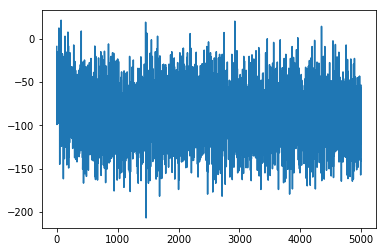

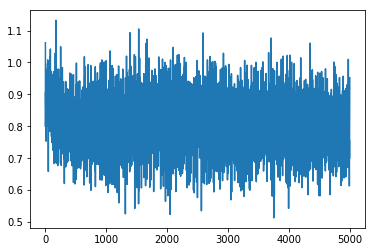

In [22]:
import matplotlib.pyplot as plt 
%matplotlib inline

plt.figure()
plt.plot(select_loss_list)
plt.show()

plt.figure()
plt.plot(rank_loss_list)
plt.show()

In [23]:
torch.save(select_net, "qcentric.model")
torch.save(rank_net, "deeprank.model")

PicklingError: Can't pickle <class 'deeprank.select_module.group_pointer_net.GroupPointerNet'>: it's not the same object as deeprank.select_module.group_pointer_net.GroupPointerNet

In [ ]:
select_net_e = torch.load(f='qcentric.model')
rank_net_e = torch.load(f='deeprank.model')

list_gen = ListGenerator(rel_file=Letor07Path+'/relation.test.fold%d.txt'%(letor_config['fold']),
                         config=letor_config)
map_v = 0.0
map_c = 0.0

with torch.no_grad():
    for X1, X1_len, X1_id, X2, X2_len, X2_id, Y, F in \
        list_gen.get_batch(data1=loader.query_data, data2=loader.doc_data):
        #print(X1.shape, X2.shape, Y.shape)
        X1, X1_len, X2, X2_len, Y, F = to_device(X1, X1_len, X2, X2_len, Y, F, device=select_device)
        X1, X2, X1_len, X2_len, X2_pos = select_net_e(X1, X2, X1_len, X2_len, X1_id, X2_id)
        X2, X2_len = utils.data_adaptor(X2, X2_len, select_net, rank_net, letor_config)
        #print(X1.shape, X2.shape, Y.shape)
        pred = rank_net_e(X1, X2, X1_len, X2_len, X2_pos)
        map_o = utils.eval_MAP(pred.tolist(), Y.tolist())
        #print(pred.shape, Y.shape)
        map_v += map_o
        map_c += 1.0
    map_v /= map_c

print('[Test]', map_v)